# Final Version 3

<b><i> Identified [Aim](#aim) of the project as, see link to later in document

### External Modules

In [1]:
import numpy as np
import pandas as pd
import ADRpy as ADR
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.optimize import newton
from ADRpy import atmospheres as at

In [2]:
plt.rcParams["figure.figsize"]=15,10 #Set plot size
plt.rcParams.update({'font.size': 16}) #set plot size font
plt.rcParams.update({"axes.grid" : True, "grid.color": "lightgrey"}) #Add grid lines to plot

### Conversions

In [3]:
def Knots(MS):
    return MS / 0.5144

def MS(Knots):
    return Knots * 0.5144

def radian(degree):
    return degree * np.pi/180

def Feet2M(feet):
    return feet / 3.281

### Environment Parameters

In [4]:
g = 9.81        #Gravitational Constant
rho = 1.225

# Wind Speed / Direcion
#     Headwind +ve
#     Cross wind +ve from right
w_vel = 0
w_deg = 0

mu = 0.05    #Driction Coefficient to Runway Surface

temp_c = 15     #Airfield OAT temperacture in celcius
alt_ft = 66     #Airfield (runway) altitude in feet
RunwayLength = 1650

In [5]:
# Vw = MS(5) #5 kt headwind
Vw = 5

#### Calculate $\rho$ at Airfield Temp and Altitude

In [6]:
def sealevel(t):
    isa_offset = at.Atmosphere(offset_deg=t)
    return isa_offset.airtemp_c(Feet2M(alt_ft)) - temp_c

In [7]:
isa_offset = at.Atmosphere(offset_deg=newton(sealevel,0))
rho = isa_offset.airdens_kgpm3(Feet2M(alt_ft))
rho

1.2220811339457178

### Aircraft Parameters

#### Airframe

In [8]:
m = 78000        #Mass

S = 122.6        #Wing Area
h_W = 3.38      #Height of wing above the ground

b = 34.1       #Wingspan

c = S/b       #Chord length

In [9]:
A = (b**2)/S
e = 0.85
a0 = 2*np.pi
alpha_0L = - radian(2)

def CL(alpha):
    alpha1 = radian(alpha)
    return a0 * ((np.pi*A*e)/(np.pi*A*e + a0)) * (alpha1 - alpha_0L)

#def Cl(alpha):
#    a0 = 2*np.pi
#    alpha0 = radian(2)
#    
#    return a0*(alpha + alpha0/57.3)

In [10]:
CD0 = 0.02

#### Engine Thrust

In [11]:
T_L = 120.6 * 1e3  
T_R = 120.6 * 1e3   

<hr style="height:1px;border-width:0;color:black;background-color:black">

### Key Functions

- Lift
- Drag
- Ground Effect
- Friction
- Induced Drag
- phi

In [12]:
def Lift(V,alpha):
    return 0.5 * rho * V**2 * S * CL(alpha)

def Drag(V,alpha):
    return None

def D_i(V,alpha):
    return 0

def D(V,h,alpha):
    return 0.5 * rho * V**2 * S * (CD0 + phi(h) * (CL(alpha)**2)/(np.pi * e * A))

def D_f(V,alpha):
    R = m*g - Lift(V,alpha)
    return mu * R

def phi(h_alt):
    h = h_alt + h_W
    phi = ((16*h/b)**2)/((1+((16*h/b)**2)))
    if phi > 1:
        phi = 1
    return phi

<hr style="height:1px;border-width:0;color:black;background-color:black">

### Calculating Stall Speed

For stall speed, the lift equals the weight of the aircraft. i.e $L=\frac{1}{2}\rho V^{2}C_{L}S=W=mg$
<br> 
Rearranging for V: $V= \sqrt{\frac{2mg}{\rho C_{L}S}}$

In [33]:
CL_max = CL(12)
V_s = np.sqrt((2*m*g)/(rho * S * CL_max))
Knots(V_s)

177.14514998787863

### Calculating Rotation Speed

In [34]:
V2 = 1.2 * V_s
Knots(V2), V2

(212.57417998545432, 109.3481581845177)

#### Key Speeds:
- Vr : Speed at which rotation is initiated so that aircraft clears 35ft screen height
- V1 : Decision speed, maximum speed for Rejected Take Off
- V2 : Min climb speed OEI, must be reached by 35ft
- Vs : Stall Speed @ max CL
- VLOF : Aircraft leaves the ground
- VEF : Engine Failure Speed ~1-2 secs before V1

<div class="alert alert-block alert-info">
V1 is found by conducting the balanced field investigation for the parameters entered. <br><br> <a id='aim'></a><b> Aim to create a monte carlo analysis of balanced field lengths for a number of different aircraft parameters (should be able to input array for each of the paramters listed under Aircraft Parameters and Environmental Parameters sections above </b>
</div>

<hr style="height:1px;border-width:0;color:black;background-color:black">

# AEO

## Accelerate - Stop

### Accelerate

In [36]:
%%time
V_abort = 150

def rollout(t,y):
    Vx = y[0]
    X = y[1]
    
    dVxdt = (1/m) * ((T_L + T_R) - D(Vx,0,0) - D_f(Vx,0))
    dXdt = Vx - Vw
    
    return np.array([dVxdt,dXdt])

def Abort(t,y):
    Vx = y[0]
    return Vx - MS(V_abort)
Abort.terminal = True

x0 = 0
v0 = 0
y0 = np.array([v0,x0])

sol_rollout = solve_ivp(rollout,[0,40],y0,rtol=1e-9,max_step=1e-3,events=[Abort])

Wall time: 3.39 s


In [37]:
print('Vx : ', sol_rollout.y[0][-1])
print('X  : ', sol_rollout.y[1][-1])
print('t  : ', sol_rollout.t[-1])

Vx :  77.16
X  :  1009.994186304113
t  :  29.923143540054824


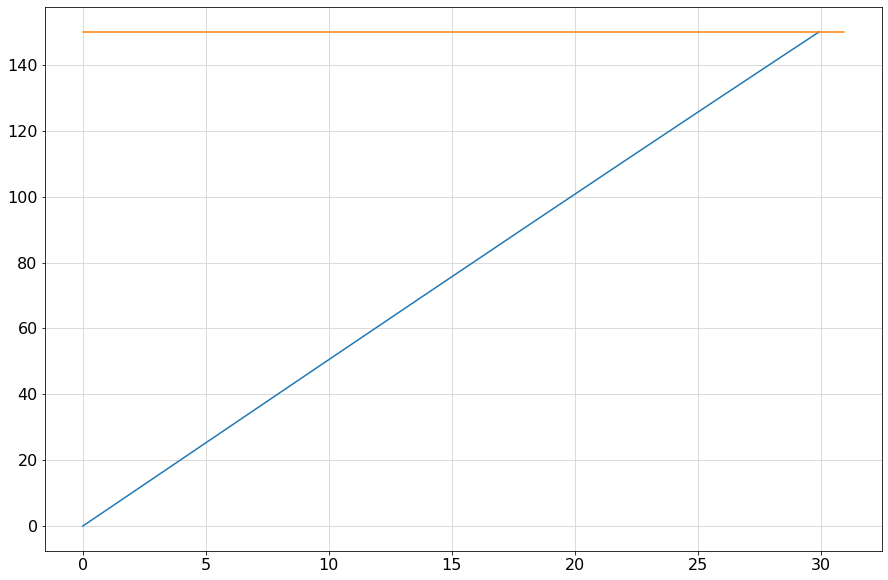

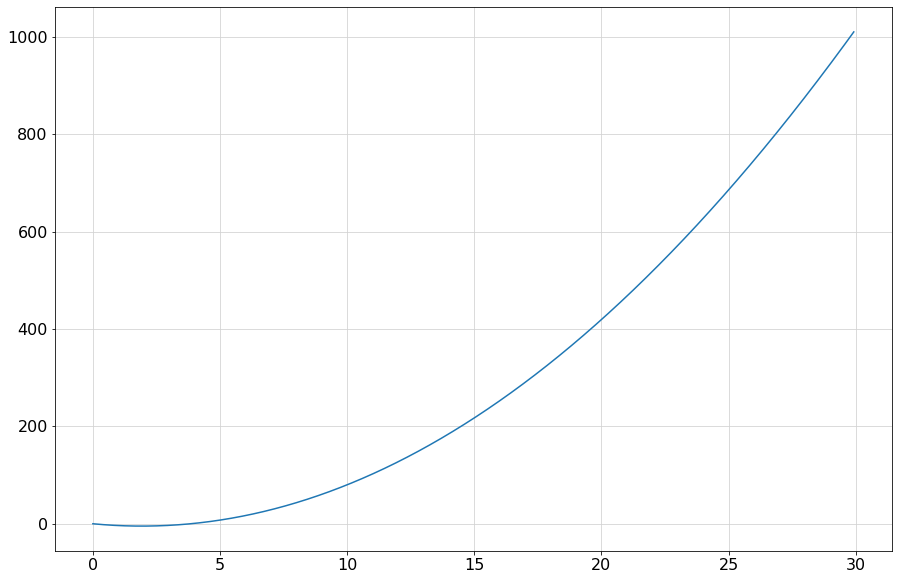

In [38]:
plt.plot(sol_rollout.t,Knots(sol_rollout.y[0]))
plt.plot([0,sol_rollout.t[-1]+1],[V_abort,V_abort])
plt.show()
plt.plot(sol_rollout.t,sol_rollout.y[1])
plt.show()

### Stopping

In [39]:
%%time
def brake(t,y):
    Vx = y[0]
    X = y[1]
    
    dVxdt = -0.5 * g
    dXdt = Vx - Vw
    
    return np.array([dVxdt,dXdt])

def stop(t,y):
    Vx = y[0]
    return Vx
stop.terminal = True

x0 = sol_rollout.y[1][-1]
v0 = sol_rollout.y[0][-1]
y0 = np.array([v0,x0])

sol_brake = solve_ivp(brake,[0,40],y0,rtol=1e-9,max_step=1e-3,events=[stop])

Wall time: 1.27 s


In [40]:
sol_brake.t[-1]

15.730886850155589

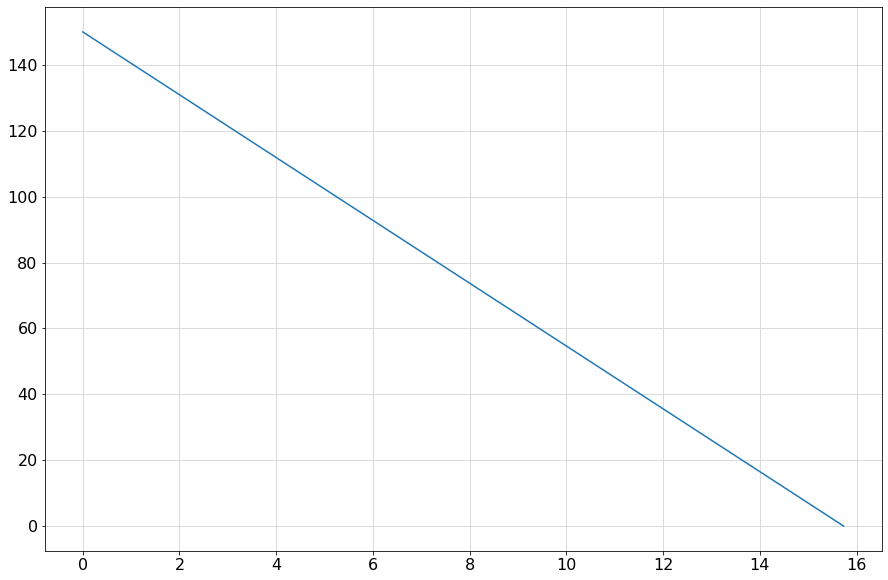

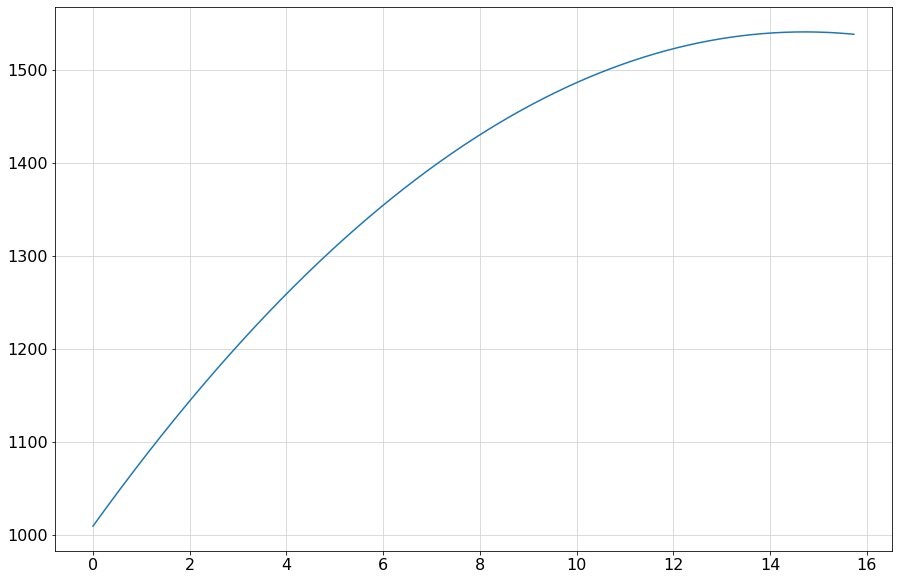

In [41]:
plt.plot(sol_brake.t,Knots(sol_brake.y[0]))
plt.show()
plt.plot(sol_brake.t,sol_brake.y[1])
plt.show()

In [42]:
print('Run stopped at {:.6f}'.format(sol_brake.t[-1]))
print('Run length     {:.6f}'.format(sol_brake.y[1][-1]))

Run stopped at 15.730887
Run length     1538.237367


## Take-off to 35ft

Notes:
 - For engine failure, thrust is dependent on the velocity, cut engine at speed just after V1

### Ground Run

In [43]:
%%time

def rollout(t,y):
    Vx = y[0]
    X = y[1]
    
    dVxdt = (1/m) * ((T_L + T_R) - D(Vx,0,0) - D_f(Vx,0))
    dXdt = Vx - Vw
    
    return np.array([dVxdt,dXdt])

Vr = 170

def Vr_set(t,y):
    Vx = y[0]
    return Vx - MS(Vr)
Vr_set.terminal = True

x0 = 0
v0 = 0
y0 = np.array([v0,x0])

sol_rollout = solve_ivp(rollout,[0,50],y0,rtol=1e-9,max_step=1e-3,events=[Vr_set])

Wall time: 3.91 s


In [44]:
print('Vx : ', sol_rollout.y[0][-1])
print('X  : ', sol_rollout.y[1][-1])

Vx :  87.44799999999998
X  :  1325.2349938194534


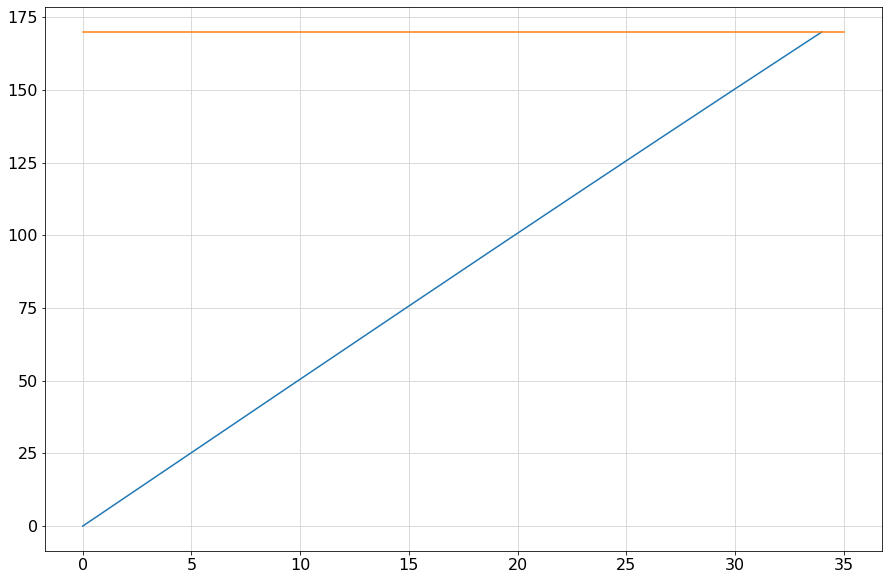

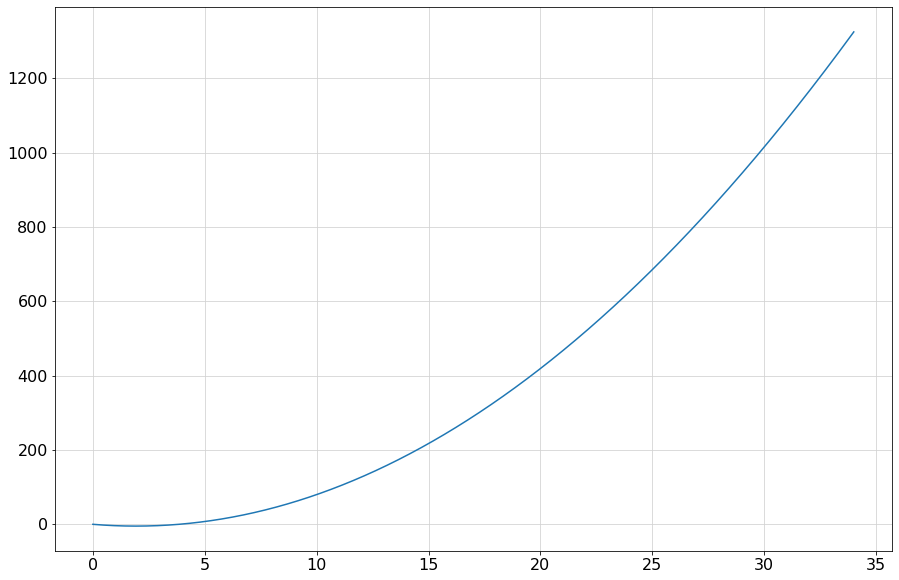

In [45]:
plt.plot(sol_rollout.t,Knots(sol_rollout.y[0]))
plt.plot([0,sol_rollout.t[-1]+1],[Vr,Vr])
plt.show()
plt.plot(sol_rollout.t,sol_rollout.y[1])
plt.show()

### Transition / Rotate

Remember:
 - Friction still present in roatation
 - Change in AoA
 - Track Angle remains 0
 

In [46]:
rotate_rate = 5

#V_LOF - Lift=Weight
def LOF(t,y):
    L = Lift(y[0],y[2])*np.cos(np.radians(y[2]))    
    W = m * g
    return L - W
LOF.terminal = True

def rotate(t,y):
    Vx = y[0]
    X = y[1]
    Alpha = y[2]
    
    dVxdt = (1/m) * ((T_L + T_R)*np.cos(np.radians(Alpha)) - D(Vx,0,Alpha) - D_f(Vx,Alpha))
    dAlphadt = rotate_rate
    dXdt = Vx - Vw
    
    return np.array([dVxdt,dXdt,dAlphadt])

In [47]:
# initial conditions
x0  = sol_rollout.y[1][-1] # initial s
vx0 = sol_rollout.y[0][-1] # initial v
alpha0 = 0

# combine s and v into array y0
y0 = np.array([vx0,x0,alpha0])

sol_rotate = solve_ivp(rotate,[0,20],y0,rtol=1e-9,max_step = 1e-3,events=[LOF])

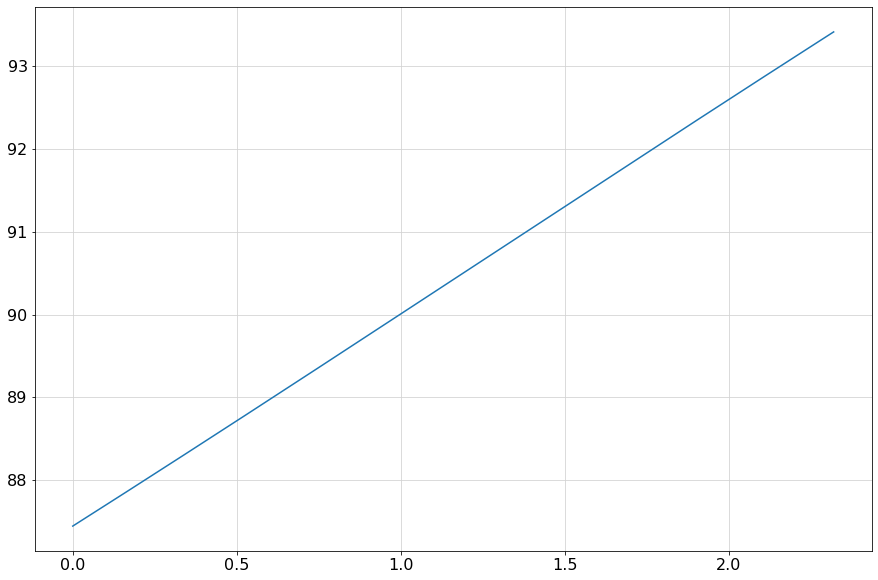

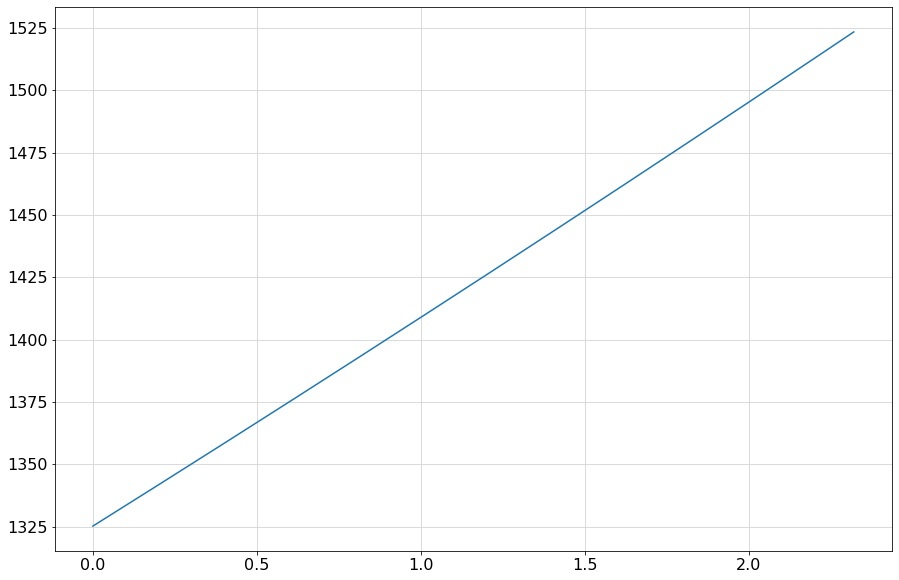

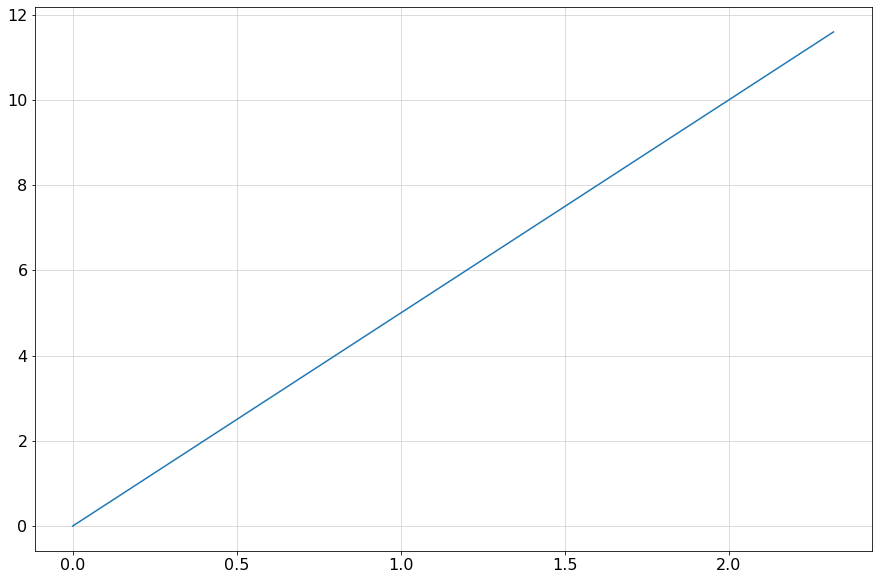

In [48]:
plt.plot(sol_rotate.t,sol_rotate.y[0]) # vx
plt.show()
plt.plot(sol_rotate.t,sol_rotate.y[1]) # x
plt.show()
plt.plot(sol_rotate.t,sol_rotate.y[2]) # alpha
plt.show()

### Climb Out to 35ft

In [49]:
alpha = theta = sol_rotate.y[2][-1]
alpha

11.600397842406226

In [50]:
%%time

def ScreenHeight(t,y):
    return y[3] - 10.7
ScreenHeight.terminal = True

def f(t,y):
    Vx = y[0]  
    Vz = y[1]
    X = y[2]              # extract v from array y 
    H = y[3]
    
    V = np.sqrt(Vx**2 + Vz**2)

    dVxdt = (1/m) * ((T_L + T_R)*np.cos(np.radians(theta)) - D(V,0,theta)*np.cos(np.radians(theta)) - Lift(V,theta)*np.sin(np.radians(theta)))
    dVzdt = (1/m) * ((T_L + T_R)*np.sin(np.radians(theta)) + Lift(V,theta)*np.cos(np.radians(theta)) - m*g - D(V,0,theta)*np.sin(np.radians(theta)))
    dXdt = Vx - Vw
    dHdt = Vz
    
    return np.array([dVxdt, dVzdt, dXdt, dHdt]) # return array


# initial conditions
x0 = sol_rotate.y[1][-1] # initial s
vz0 = 0 # initial v
h0 = 0
vx0 = sol_rotate.y[0][-1]

# combine s and v into array y0
y0 = np.array([vx0,vz0,x0,h0])

sol_LOF = solve_ivp(f,[0,40],y0,rtol=1e-9,max_step = 1e-3,events=[ScreenHeight])

Wall time: 1.44 s


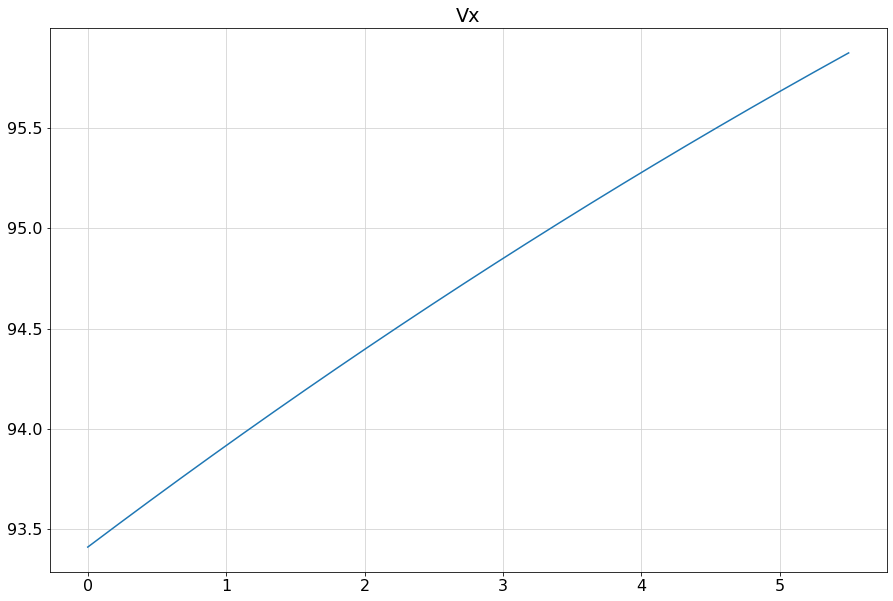

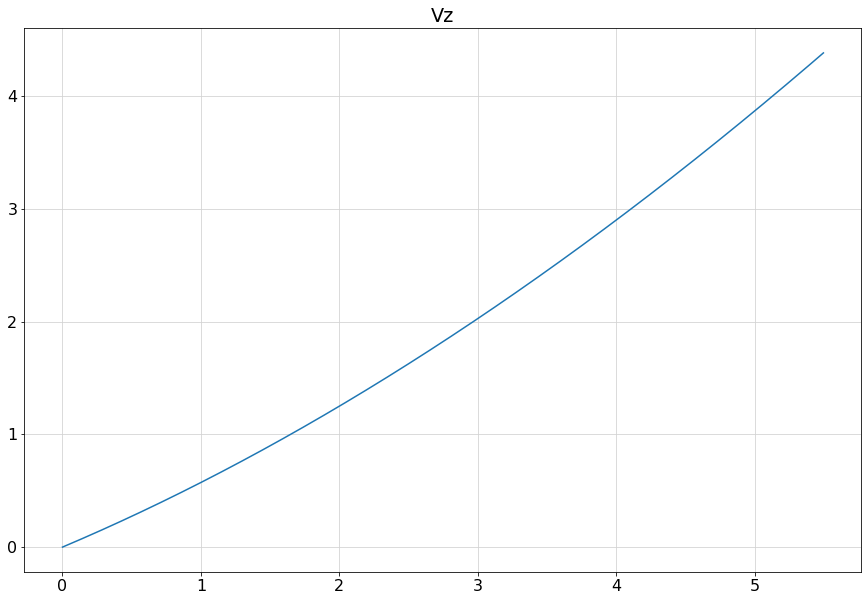

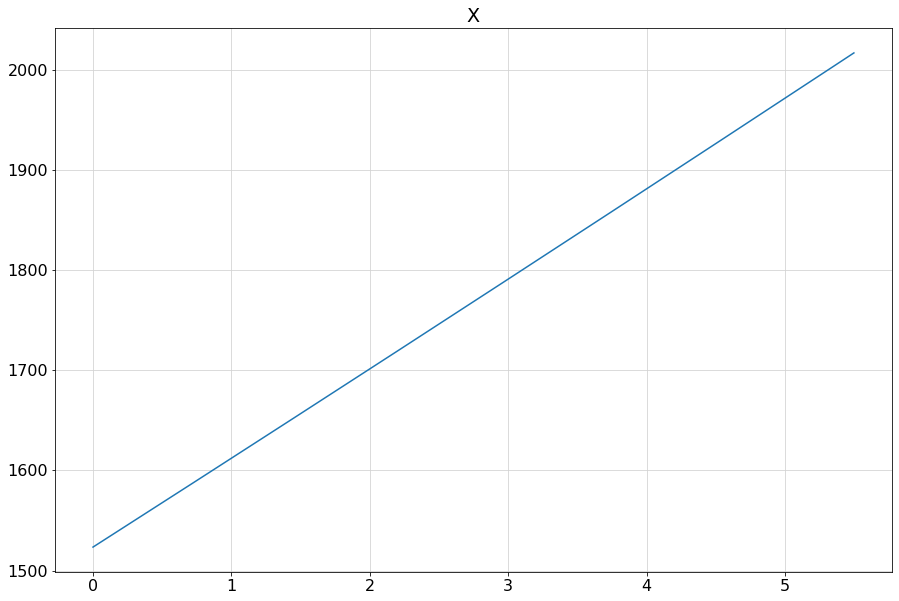

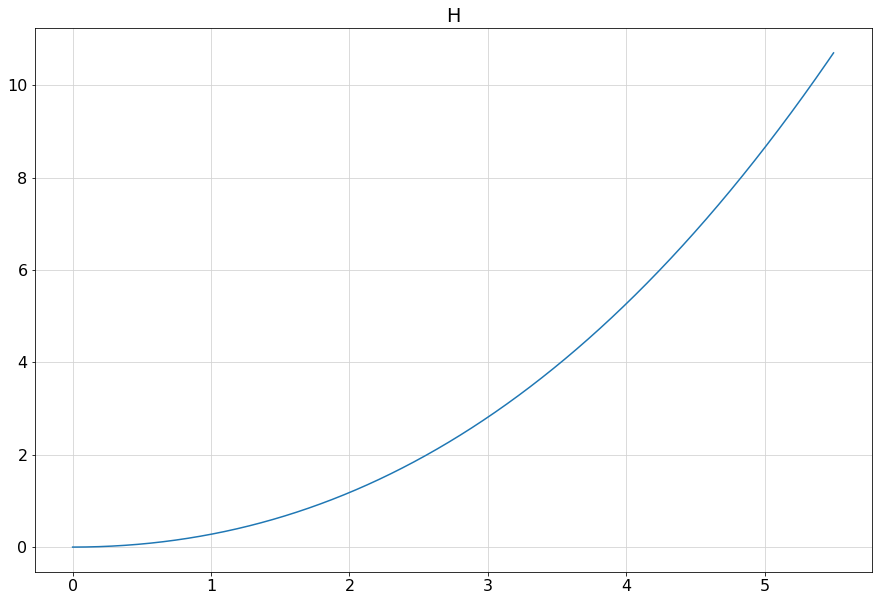

In [51]:
plt.title('Vx')
plt.plot(sol_LOF.t,sol_LOF.y[0])
plt.show()
plt.title('Vz')
plt.plot(sol_LOF.t,sol_LOF.y[1])
plt.show()
plt.title('X')
plt.plot(sol_LOF.t,sol_LOF.y[2])
plt.show()
plt.title('H')
plt.plot(sol_LOF.t,sol_LOF.y[3])
plt.show()

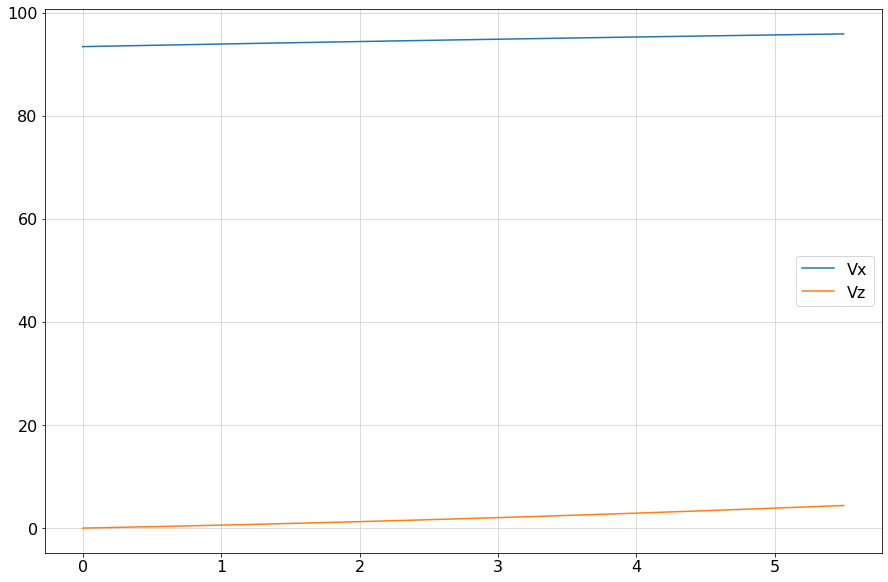

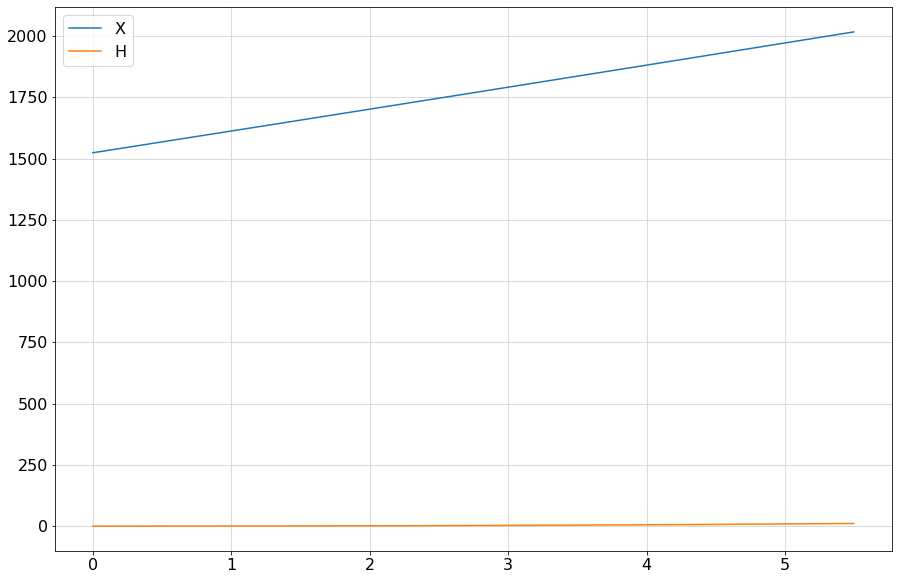

In [52]:
plt.plot(sol_LOF.t,sol_LOF.y[0],label = 'Vx')
plt.plot(sol_LOF.t,sol_LOF.y[1],label = 'Vz')
plt.legend()
plt.show()
plt.plot(sol_LOF.t,sol_LOF.y[2],label = 'X')
plt.plot(sol_LOF.t,sol_LOF.y[3],label = 'H')
plt.legend()
plt.show()

In [53]:
sol_LOF.y[2][-1]

2016.5742858548638

In [54]:
Knots(sol_LOF.y[0][-1])

186.38280600488469

In [55]:
Knots(sol_LOF.y[1][-1])

8.527127501163934

In [56]:
np.sqrt((Knots(sol_LOF.y[0][-1]))**2+(Knots(sol_LOF.y[1][-1]))**2)

186.57776469256882

In [57]:
at = np.arctan(sol_LOF.y[1][-1]/sol_LOF.y[0][-1])

In [58]:
np.degrees(at)

2.619490380623463

pitch angle / track angle / speed / speed at screen height

# V1 AEO Acc-Stop

In [59]:
%%time
V_abort = 150

def accel(t,y):
    Vx = y[0]
    X = y[1]
    
    dVxdt = (1/m) * ((T_L + T_R) - D(Vx,0,0) - D_f(Vx,0))
    dXdt = Vx - Vw
    return np.array([dVxdt,dXdt])

def brake(t,y):
    Vx = y[0]
    X = y[1]
    
    dVxdt = -0.5 * g
    dXdt = Vx - Vw
    
    return np.array([dVxdt,dXdt])

def Abort(t,y):
    Vx = y[0]
    return Vx - MS(V_abort)
Abort.terminal = True

def stop(t,y):
    Vx = y[0]
    return Vx
stop.terminal = True


x0 = 0
v0 = 0
y0 = np.array([v0,x0])
sol_rollout = solve_ivp(accel,[0,40],y0,rtol=1e-9,max_step=1e-3,events=[Abort])

x0 = sol_rollout.y[1][-1]
v0 = sol_rollout.y[0][-1]
y0 = np.array([v0,x0])
sol_brake = solve_ivp(brake,[0,40],y0,rtol=1e-9,max_step=1e-3,events=[stop])

Wall time: 4.73 s


In [60]:
sol_brake.y[1][-1]

1538.237366732443

In [61]:
def find_V1(V_t):
    def V1Abort(t,y):
        Vx = y[0]
        return Vx - MS(V_t)
    V1Abort.terminal = True

    print(V_t)
    
    x0 = 0
    v0 = 0
    y0 = np.array([v0,x0])
    sol_accel = solve_ivp(accel,[0,100],y0,rtol=1e-9,max_step=1e-3,events=[V1Abort])

    x0 = sol_accel.y[1][-1]
    v0 = sol_accel.y[0][-1]
    y0 = np.array([v0,x0])
    sol_brake = solve_ivp(brake,[0,100],y0,rtol=1e-9,max_step=1e-3,events=[stop])
    
    return sol_brake.y[1][-1] - RunwayLength

In [62]:
find_V1(150)

150


-111.76263326755702

In [63]:
newton(find_V1,160)

160.0
160.0161
155.0277156347577


154.9406170011983

In [65]:
V_abort = newton(find_V1,160)

x0 = 0
v0 = 0
y0 = np.array([v0,x0])
sol_rollout = solve_ivp(accel,[0,100],y0,rtol=1e-9,max_step=1e-3,events=[Abort])

x0 = sol_rollout.y[1][-1]
v0 = sol_rollout.y[0][-1]
y0 = np.array([v0,x0])
sol_brake = solve_ivp(brake,[0,40],y0,rtol=1e-9,max_step=1e-3,events=[stop])

160.0
160.0161
155.0277156347577
154.9406170011983
154.93903851928872
154.93903801994756


In [66]:
sol_brake.y[1][-1]

1650.0

In [67]:
V_abort = np.floor(V_abort)

x0 = 0
v0 = 0
y0 = np.array([v0,x0])
sol_rollout = solve_ivp(accel,[0,100],y0,rtol=1e-9,max_step=1e-3,events=[Abort])

x0 = sol_rollout.y[1][-1]
v0 = sol_rollout.y[0][-1]
y0 = np.array([v0,x0])
sol_brake = solve_ivp(brake,[0,40],y0,rtol=1e-9,max_step=1e-3,events=[stop])
sol_brake.y[1][-1]

1628.442852912196

In [68]:
V_abort

154.0

# V1 OEI Acc-Stop

In [69]:
V_ef = 150

def toVef(t,y):
    Vx = y[0]
    X = y[1]
    
    dVxdt = (1/m) * ((T_L + T_R) - D(Vx,0,0) - D_f(Vx,0))
    dXdt = Vx - Vw
    return np.array([dVxdt,dXdt])

def VefV1(t,y):
    Vx = y[0]
    X = y[1]
    
    dVxdt = (1/m) * ((0 + T_R) - D(Vx,0,0) - D_f(Vx,0))
    dXdt = Vx - Vw
    return np.array([dVxdt,dXdt])

def V1stop(t,y):
    Vx = y[0]
    X = y[1]
    
#     dVxdt = -(1/m)*(D(Vx,0,0) + D_f(Vx,0)) - 0.25*g
    dVxdt = - 0.5*g
    dXdt = Vx - Vw
    
    return np.array([dVxdt,dXdt])

def EngineFail(t,y):
    Vx = y[0]
    return Vx - MS(V_ef)
EngineFail.terminal = True  

def stop(t,y):
    Vx = y[0]
    return Vx
stop.terminal = True


x0 = 0
v0 = 0
y0 = np.array([v0,x0])
sol_Vef = solve_ivp(toVef,[0,40],y0,rtol=1e-9,max_step=1e-3,events=[EngineFail])

x0 = sol_Vef.y[1][-1]
v0 = sol_Vef.y[0][-1]
y0 = np.array([v0,x0])
sol_V1 = solve_ivp(VefV1,[0,2],y0,rtol=1e-9,max_step=1e-3)

x0 = sol_V1.y[1][-1]
v0 = sol_V1.y[0][-1]
y0 = np.array([v0,x0])
sol_brake = solve_ivp(V1stop,[0,40],y0,rtol=1e-9,max_step=1e-3,events=[stop])

In [70]:
sol_brake.y[1][-1]

1713.8982947196453

In [71]:
Vx = MS(150)
(1/m) * ((T_L + T_R) - D(Vx,0,0) - D_f(Vx,0)), (1/m) * ((0 + T_R) - D(Vx,0,0) - D_f(Vx,0))

(2.5326993018018173, 0.9865454556479712)

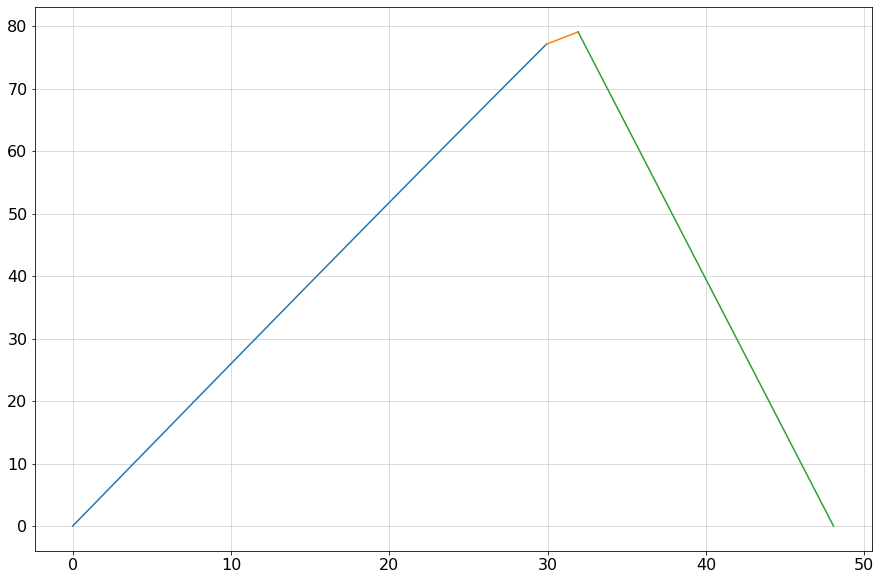

In [72]:
plt.plot(sol_Vef.t,sol_Vef.y[0])
plt.plot(sol_V1.t + sol_Vef.t[-1],sol_V1.y[0])
plt.plot(sol_brake.t + sol_V1.t[-1] + sol_Vef.t[-1],sol_brake.y[0])

In [73]:
def find_V1_OEI(V_ef):
    def EngineFail(t,y):
        Vx = y[0]
        return Vx - MS(V_ef)
    EngineFail.terminal = True  

    x0 = 0
    v0 = 0
    y0 = np.array([v0,x0])
    sol_Vef = solve_ivp(toVef,[0,40],y0,rtol=1e-9,max_step=1e-3,events=[EngineFail])

    x0 = sol_Vef.y[1][-1]
    v0 = sol_Vef.y[0][-1]
    y0 = np.array([v0,x0])
    sol_V1 = solve_ivp(VefV1,[0,2],y0,rtol=1e-9,max_step=1e-3)

    x0 = sol_V1.y[1][-1]
    v0 = sol_V1.y[0][-1]
    y0 = np.array([v0,x0])
    sol_brake = solve_ivp(V1stop,[0,40],y0,rtol=1e-9,max_step=1e-3,events=[stop])
    
    return sol_brake.y[1][-1] - RunwayLength

In [74]:
find_V1_OEI(160)

306.36457190931606

In [75]:
newton(find_V1_OEI,160)

147.24628176739236

In [76]:
V_ef = newton(find_V1_OEI,160,tol=1e-0)

x0 = 0
v0 = 0
y0 = np.array([v0,x0])
sol_Vef = solve_ivp(toVef,[0,40],y0,rtol=1e-9,max_step=1e-3,events=[EngineFail])

x0 = sol_Vef.y[1][-1]
v0 = sol_Vef.y[0][-1]
y0 = np.array([v0,x0])
sol_V1 = solve_ivp(VefV1,[0,2],y0,rtol=1e-9,max_step=1e-3)

x0 = sol_V1.y[1][-1]
v0 = sol_V1.y[0][-1]
y0 = np.array([v0,x0])
sol_brake = solve_ivp(V1stop,[0,40],y0,rtol=1e-9,max_step=1e-3,events=[stop])

In [77]:
sol_brake.y[1][-1]

1650.5300896140527

In [78]:
V_ef = np.floor(V_ef)

x0 = 0
v0 = 0
y0 = np.array([v0,x0])
sol_Vef = solve_ivp(toVef,[0,40],y0,rtol=1e-9,max_step=1e-3,events=[EngineFail])

x0 = sol_Vef.y[1][-1]
v0 = sol_Vef.y[0][-1]
y0 = np.array([v0,x0])
sol_V1 = solve_ivp(VefV1,[0,2],y0,rtol=1e-9,max_step=1e-3)

x0 = sol_V1.y[1][-1]
v0 = sol_V1.y[0][-1]
y0 = np.array([v0,x0])
sol_brake = solve_ivp(V1stop,[0,40],y0,rtol=1e-9,max_step=1e-3,events=[stop])

In [79]:
V_ef

147.0

In [80]:
V1 = sol_brake.y[0][0]
Knots(V1)

150.83955064137356

## find V1 (Vef)

In [81]:
V1 = 160

from scipy.integrate import solve_bvp


def find_V1_OEI(V1):
    def EngineFail(t,y):
        Vx = y[0]
        return Vx - V_ef
    EngineFail.terminal = True
    def Abort(t,y):
        Vx = y[0]
        return Vx - MS(V1)
    Abort.terminal = True
    
    #starting at V1 and going 2 seconds back to get Vef
    #V1 to Vef (t -ve)
    x0 = 0
    v0 = MS(V1)
    y0 = np.array([v0,x0])
    sol_V1Vef = solve_ivp(VefV1,[2,0],y0,rtol=1e-9,max_step=1e-3)
     
    V_ef =  sol_V1Vef.y[0][-1]
    #Solve given the calculated Vef
    x0 = 0
    v0 = 0
    y0 = np.array([v0,x0])
    sol_Vef = solve_ivp(toVef,[0,40],y0,rtol=1e-9,max_step=1e-3,events=[EngineFail])

    x0 = sol_Vef.y[1][-1]
    v0 = sol_Vef.y[0][-1]
    y0 = np.array([v0,x0])
    sol_V1 = solve_ivp(VefV1,[0,40],y0,rtol=1e-9,max_step=1e-3, events=[Abort])

    x0 = sol_V1.y[1][-1]
    v0 = sol_V1.y[0][-1]
    y0 = np.array([v0,x0])
    sol_brake = solve_ivp(V1stop,[0,40],y0,rtol=1e-9,max_step=1e-3,events=[stop])
       
    return sol_brake.y[1][-1] - RunwayLength

In [82]:
find_V1_OEI(160)

212.15370318615828

In [83]:
newton(find_V1_OEI,160)

151.0849572621653

In [84]:
V1 = np.floor(newton(find_V1_OEI,160))

def EngineFail(t,y):
    Vx = y[0]
    return Vx - V_ef
EngineFail.terminal = True
def Abort(t,y):
    Vx = y[0]
    return Vx - MS(V1)
Abort.terminal = True
    
#starting at V1 and going 2 seconds back to get Vef
#V1 to Vef (t -ve)
x0 = 0
v0 = MS(V1)
y0 = np.array([v0,x0])
sol_V1Vef = solve_ivp(VefV1,[2,0],y0,rtol=1e-9,max_step=1e-3)
     
V_ef =  sol_V1Vef.y[0][-1]
#Solve given the calculated Vef
x0 = 0
v0 = 0
y0 = np.array([v0,x0])
sol_Vef = solve_ivp(toVef,[0,40],y0,rtol=1e-9,max_step=1e-3,events=[EngineFail])

x0 = sol_Vef.y[1][-1]
v0 = sol_Vef.y[0][-1]
y0 = np.array([v0,x0])
sol_V1 = solve_ivp(VefV1,[0,40],y0,rtol=1e-9,max_step=1e-3, events=[Abort])

x0 = sol_V1.y[1][-1]
v0 = sol_V1.y[0][-1]
y0 = np.array([v0,x0])
sol_brake = solve_ivp(V1stop,[0,40],y0,rtol=1e-9,max_step=1e-3,events=[stop])

In [85]:
sol_brake.y[1][-1]

1648.0413090079319

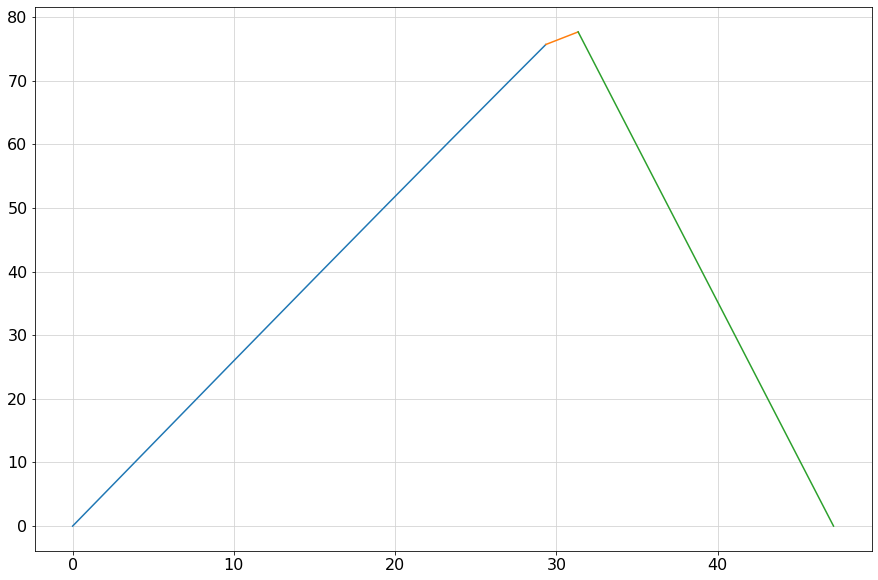

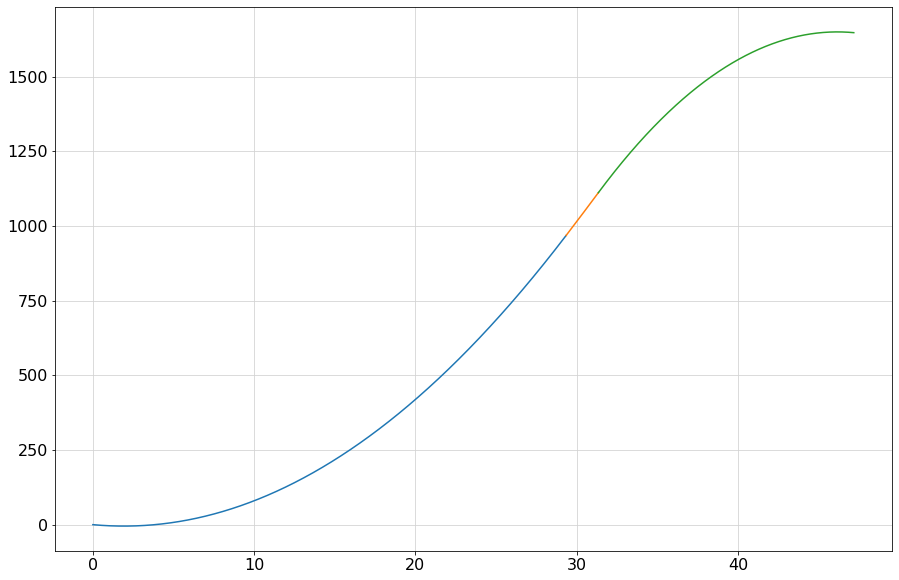

In [86]:
plt.plot(sol_Vef.t,sol_Vef.y[0])
plt.plot(sol_V1.t + sol_Vef.t[-1],sol_V1.y[0])
plt.plot(sol_brake.t + sol_V1.t[-1] + sol_Vef.t[-1],sol_brake.y[0])
plt.show()

plt.plot(sol_Vef.t,sol_Vef.y[1])
plt.plot(sol_V1.t + sol_Vef.t[-1],sol_V1.y[1])
plt.plot(sol_brake.t + sol_V1.t[-1] + sol_Vef.t[-1],sol_brake.y[1])
plt.show()

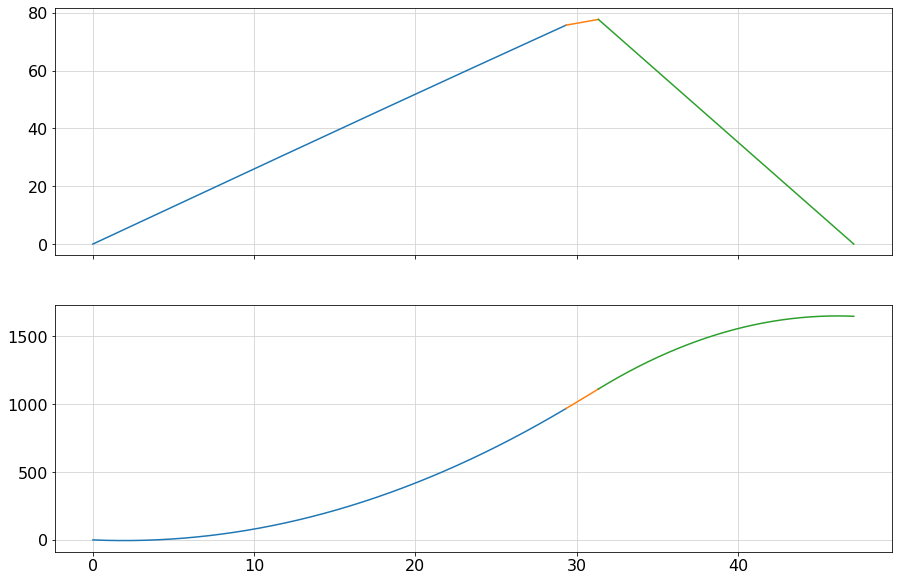

In [87]:
fig, (ax0, ax1) = plt.subplots(2, sharex=True)

ax0.plot(sol_Vef.t,sol_Vef.y[0])
ax0.plot(sol_V1.t + sol_Vef.t[-1],sol_V1.y[0])
ax0.plot(sol_brake.t + sol_V1.t[-1] + sol_Vef.t[-1],sol_brake.y[0])

ax1.plot(sol_Vef.t,sol_Vef.y[1])
ax1.plot(sol_V1.t + sol_Vef.t[-1],sol_V1.y[1])
ax1.plot(sol_brake.t + sol_V1.t[-1] + sol_Vef.t[-1],sol_brake.y[1])

## find V1 (Vef) {Refined (Varying the thrust})

In [13]:
def SDF_FC(T0,t):
    def model(x,a,n,b,c,d,e,f,x0,x1):
        conds = [x<x0, (x>=x0) & (x<x1),x>=x1]
        funcs = [lambda x:1+a*x**n,lambda x:(b/x) + c*np.exp(-d*x) + e/np.sqrt(x) + f, 0]
        return np.piecewise(x,condlist=conds,funclist=funcs)
    return T0 * model(float(t),-5,3.25,-0.068,1.249,2.419,0.291,-0.108,0.25,5.5)

def SDF_TC(T0,t):
    def model(x,a,b,c,d,e,x0,x1):
        conds = [x<x0, (x>=x0) & (x<x1),x>=x1]
        funcs = [1,lambda x:(a/x) + b*np.exp(-c*x) + d/np.sqrt(x) + e, (a/x1) + b*np.exp(-c*x1) + d/np.sqrt(x1) + e]
        return np.piecewise(x,condlist=conds,funclist=funcs)
    return T0 * model(float(t),-0.261,1.280,1.345,0.612,-0.073,0.39,12)

 
def toVef(t,y):
    Vx = y[0]
    X = y[1]
    
    dVxdt = (1/m) * ((T_L + T_R) - D(Vx,0,0) - D_f(Vx,0))
    dXdt = Vx - Vw
    dTdt = 0
    
    return np.array([dVxdt,dXdt])

def VefV1(t,y,t_Vef):
    Vx = y[0]
    X = y[1]
    
    dVxdt = (1/m) * ((SDF_FC(T_L,t - t_Vef) + T_R) - D(Vx,0,0) - D_f(Vx,0))
    dXdt = Vx - Vw
   
    return np.array([dVxdt,dXdt])


def V1stop(t,y,t_Vef,t_V1):
    Vx = y[0]
    X = y[1]

    dVxdt = (1/m) * ((SDF_FC(T_L,t - t_Vef) + SDF_TC(T_R,t-t_V1)) - D(Vx,0,0) - D_f(Vx,0)) - 0.4*g
#     dVxdt = -(1/m)*(D(Vx,0,0) + D_f(Vx,0)) - 0.25*g
#     dVxdt = - 0.5*g
    dXdt = Vx - Vw
    dT1_dt = 0
    dT2_dt = 0
    return np.array([dVxdt,dXdt])

def EngineFail(t,y):
    Vx = y[0]
    return Vx - MS(V_ef)
EngineFail.terminal = True  

def stop(t,y):
    Vx = y[0]
    return Vx
stop.terminal = True

In [14]:
def find_V1_OEI(V1):
    def EngineFail(t,y):
        Vx = y[0]
        return Vx - V_ef
    EngineFail.terminal = True
    def Abort(t,y):
        Vx = y[0]
        return Vx - MS(V1)
    Abort.terminal = True
    
    #starting at V1 and going 2 seconds back to get Vef
    #V1 to Vef (t -ve)
    x0 = 0
    v0 = MS(V1)
    y0 = np.array([v0,x0])
#     sol_V1Vef = solve_ivp(VefV1,[2,0],y0,rtol=1e-9,max_step=1e-3,args=0)
    sol_V1Vef = solve_ivp(lambda t, y: VefV1(t,y,0), [2,0], y0, rtol=1e-9, max_step=1e-3)
    
    V_ef =  sol_V1Vef.y[0][-1]
    #Solve given the calculated Vef
    
    x0 = 0
    v0 = 0
    y0 = np.array([v0,x0])
    sol_Vef = solve_ivp(toVef,[0,60],y0,rtol=1e-9,max_step=1e-3,events=[EngineFail])

    t_V_ef = sol_Vef.t[-1]
    
    x0 = sol_Vef.y[1][-1]
    v0 = sol_Vef.y[0][-1]
    y0 = np.array([v0,x0])
    sol_V1 = solve_ivp(lambda t, y: VefV1(t,y,t_V_ef),[sol_Vef.t[-1],sol_Vef.t[-1]+60],y0,rtol=1e-9,max_step=1e-3, events=[Abort])
    
    t_V1 = sol_V1.t[-1]
    
    x0 = sol_V1.y[1][-1]
    v0 = sol_V1.y[0][-1]
    y0 = np.array([v0,x0])
    sol_brake = solve_ivp(lambda t, y: V1stop(t,y,t_V_ef,t_V1),[sol_V1.t[-1],sol_V1.t[-1]+60],y0,rtol=1e-9,max_step=1e-3,events=[stop])
    return sol_brake.y[1][-1] - RunwayLength

In [ ]:
%%time

V1 = np.floor(newton(find_V1_OEI,160))

def EngineFail(t,y):
    Vx = y[0]
    return Vx - V_ef
EngineFail.terminal = True
def Abort(t,y):
    Vx = y[0]
    return Vx - MS(V1)
Abort.terminal = True
    
#starting at V1 and going 2 seconds back to get Vef
#V1 to Vef (t -ve)
x0 = 0
v0 = MS(V1)
y0 = np.array([v0,x0])
sol_V1Vef = solve_ivp(lambda t, y: VefV1(t,y,0), [2,0], y0, rtol=1e-9, max_step=1e-3)
     
V_ef =  sol_V1Vef.y[0][-1]
#Solve given the calculated Vef
x0 = 0
v0 = 0
y0 = np.array([v0,x0])
sol_Vef = solve_ivp(toVef,[0,40],y0,rtol=1e-9,max_step=1e-3,events=[EngineFail])

t_V_ef = sol_Vef.t[-1]

x0 = sol_Vef.y[1][-1]
v0 = sol_Vef.y[0][-1]
y0 = np.array([v0,x0])
sol_V1 = solve_ivp(lambda t, y: VefV1(t,y,t_V_ef),[sol_Vef.t[-1],sol_Vef.t[-1]+40],y0,rtol=1e-9,max_step=1e-3, events=[Abort])

t_V1 = sol_V1.t[-1]

x0 = sol_V1.y[1][-1]
v0 = sol_V1.y[0][-1]
y0 = np.array([v0,x0])
sol_brake = solve_ivp(lambda t, y: V1stop(t,y,t_V_ef,t_V1),[sol_V1.t[-1],sol_V1.t[-1]+40],y0,rtol=1e-9,max_step=1e-3,events=[stop])

In [ ]:
V1, sol_brake.y[1][-1]

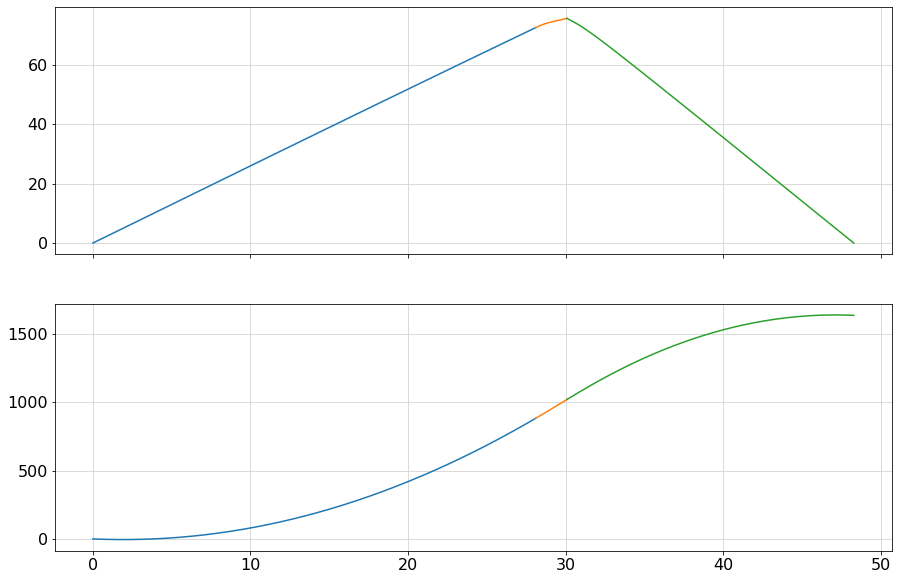

In [96]:
fig, (ax0, ax1) = plt.subplots(2, sharex=True)

ax0.plot(sol_Vef.t,sol_Vef.y[0])
ax0.plot(sol_V1.t,sol_V1.y[0])
ax0.plot(sol_brake.t,sol_brake.y[0])

ax1.plot(sol_Vef.t,sol_Vef.y[1])
ax1.plot(sol_V1.t,sol_V1.y[1])
ax1.plot(sol_brake.t,sol_brake.y[1])